<a href="https://colab.research.google.com/github/Hania111/sentiment-to-hate-analysis/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hateful_sentiment.csv to hateful_sentiment.csv


In [ ]:
uploaded = files.upload()

Saving Sentiment140_filtered.csv to Sentiment140_filtered.csv


In [ ]:
!pip install transformers
!pip install datasets
!pip install scikit-posthocs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import StratifiedKFold, ParameterGrid
import scikit_posthocs as sp

In [ ]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [ ]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [ ]:
sentiment_dataset.isnull().sum()

,0
Unnamed: 0,0
target,0
ids,0
date,0
flag,0
user,0
text,0
hate_pred,0


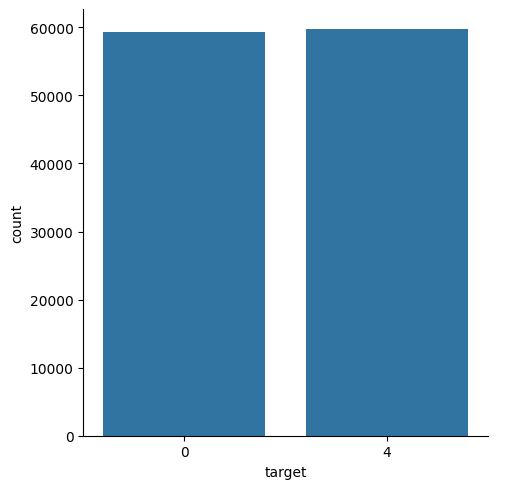

In [ ]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [ ]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [ ]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [ ]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [ ]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0
# 0 - negative, 1 - positive, 2 - hateful

In [ ]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

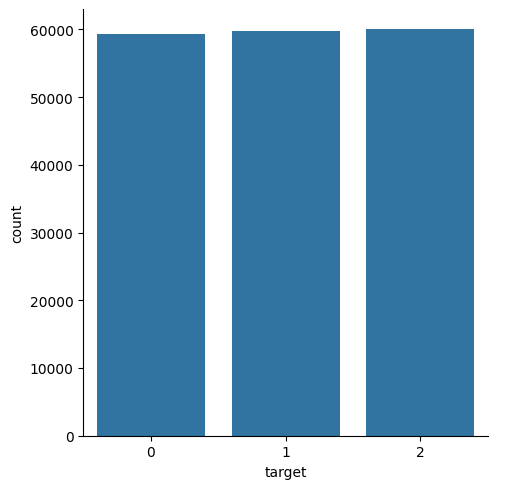

In [ ]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [ ]:
sentiment_dataset['target'].value_counts()

,count
target,
2,60000
1,59700
0,59300


In [ ]:
import os
from scipy.stats import friedmanchisquare

#Teksty i etykiety z datasetu
texts = sentiment_dataset['text']
labels = sentiment_dataset['target']

# DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Funckja tokenizacji
def tokenize(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=32)

#Liczenie metryk
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=1)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'preds': preds,
        'labels': labels
    }

# Różne hiperparametry
param_grid = list(ParameterGrid({
    'learning_rate': [2e-5],
    'per_device_train_batch_size': [16,32]
}))

#5 krotna walidacja
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Najlepszy model
best_models_info = []

# Test Friedmana
results_for_friedman = {
    'accuracy': {str(params): [] for params in param_grid},
    'precision': {str(params): [] for params in param_grid},
    'recall': {str(params): [] for params in param_grid},
    'f1': {str(params): [] for params in param_grid}
}

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\nFold {fold + 1}")

    #Dane treningowe i walidacyjne
    train_texts = texts.iloc[train_idx].tolist()
    val_texts = texts.iloc[val_idx].tolist()
    train_labels = labels.iloc[train_idx].tolist()
    val_labels = labels.iloc[val_idx].tolist()

    # Tokenizacja danych
    train_enc = tokenize(train_texts)
    val_enc = tokenize(val_texts)

    #Dataset HuggingFace z tokenów i etykiet
    train_ds = Dataset.from_dict({'input_ids': train_enc['input_ids'], 'attention_mask': train_enc['attention_mask'], 'labels': train_labels})
    val_ds = Dataset.from_dict({'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask'], 'labels': val_labels})

    # Najlepszy model po kazdym foldzie
    best_f1 = -1
    best_model_dir = None
    best_params = None
    best_metrics = None
    best_preds = None
    best_labels = None

    # Rozne kombinacja
    for params in param_grid:
        #Ładowanie modelu
        model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

        # Folder na checkpointy
        model_dir = f"./models/fold{fold+1}_lr{params['learning_rate']}_bs{params['per_device_train_batch_size']}"
        os.makedirs(model_dir, exist_ok=True)

        # Argumenty treningowe
        args = TrainingArguments(
            output_dir=model_dir,
            eval_strategy="epoch",
            num_train_epochs=3,
            per_device_train_batch_size=params['per_device_train_batch_size'],
            per_device_eval_batch_size=params['per_device_train_batch_size'],
            learning_rate=params['learning_rate'],
            logging_dir="./logs",
            report_to="none",
            save_strategy="no",
            disable_tqdm=True,
        )

        # Obiekt Trainer
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=compute_metrics
        )


        trainer.train()


        result = trainer.evaluate()

        # F1 z wynikow
        f1 = result['eval_f1']
        print(f"  Params: {params}, F1: {f1:.4f}")

        # Wyniki do testu
        results_for_friedman['accuracy'][str(params)].append(result['eval_accuracy'])
        results_for_friedman['precision'][str(params)].append(result['eval_precision'])
        results_for_friedman['recall'][str(params)].append(result['eval_recall'])
        results_for_friedman['f1'][str(params)].append(result['eval_f1'])

        # Zapisanie lepszego modelu
        if f1 > best_f1:
            best_f1 = f1
            best_model_dir = model_dir
            best_params = params
            best_metrics = result

            # Walidacja
            pred_output = trainer.predict(val_ds)
            best_preds = np.argmax(pred_output.predictions, axis=1)
            best_labels = pred_output.label_ids

        # Model i tokenizer
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)

    # Najlepszy model z folda
    best_models_info.append({
        'fold': fold + 1,
        'params': best_params,
        'model_dir': best_model_dir,
        'metrics': best_metrics,
        'preds': best_preds,
        'labels': best_labels
    })

# Po treningu macierz pomyłek
for info in best_models_info:
    cm = confusion_matrix(info['labels'], info['preds'])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {info['fold']} - Params {info['params']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Test Friedmana
print("\nFriedman test results ---")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"\nMetric: {metric}")

    data_for_test = [results_for_friedman[metric][str(params)] for params in param_grid]

    # Czy jest pięć wyników
    if all(len(lst) == 5 for lst in data_for_test):
        stat, p = friedmanchisquare(*data_for_test)
        print(f"Friedman chi-square statistic: {stat:.4f}, p-value: {p:.4f}")
        if p < 0.05:
            print('Są znaczace różnice")
        else:
            print("Nie ma znaczących różnic")



Fold 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.484, 'grad_norm': 3.612360715866089, 'learning_rate': 1.962830540037244e-05, 'epoch': 0.055865921787709494}
{'loss': 0.3568, 'grad_norm': 8.23989200592041, 'learning_rate': 1.9255865921787712e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3405, 'grad_norm': 3.5674362182617188, 'learning_rate': 1.888342644320298e-05, 'epoch': 0.16759776536312848}
{'loss': 0.3294, 'grad_norm': 3.5089786052703857, 'learning_rate': 1.8510986964618252e-05, 'epoch': 0.22346368715083798}
{'loss': 0.312, 'grad_norm': 4.836694240570068, 'learning_rate': 1.8138547486033524e-05, 'epoch': 0.27932960893854747}
{'loss': 0.3251, 'grad_norm': 1.3373876810073853, 'learning_rate': 1.776610800744879e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3302, 'grad_norm': 7.152841567993164, 'learning_rate': 1.739366852886406e-05, 'epoch': 0.39106145251396646}
{'loss': 0.3132, 'grad_norm': 2.532362699508667, 'learning_rate': 1.7021229050279332e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3123, 'grad_norm': 4.33853769302

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.435, 'grad_norm': 6.650566101074219, 'learning_rate': 1.9256610800744882e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3341, 'grad_norm': 3.6576955318450928, 'learning_rate': 1.851173184357542e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3182, 'grad_norm': 3.346391439437866, 'learning_rate': 1.7766852886405962e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3204, 'grad_norm': 2.123305559158325, 'learning_rate': 1.70219739292365e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3039, 'grad_norm': 4.120988845825195, 'learning_rate': 1.627709497206704e-05, 'epoch': 0.5586592178770949}
{'loss': 0.2988, 'grad_norm': 5.76373815536499, 'learning_rate': 1.5532216014897582e-05, 'epoch': 0.6703910614525139}
{'loss': 0.295, 'grad_norm': 4.999413967132568, 'learning_rate': 1.4787337057728119e-05, 'epoch': 0.7821229050279329}
{'loss': 0.2898, 'grad_norm': 4.022699356079102, 'learning_rate': 1.404245810055866e-05, 'epoch': 0.8938547486033519}
{'eval_loss': 0.27540141344070435, 'eval_accuracy':

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4683, 'grad_norm': 7.511023998260498, 'learning_rate': 1.962830540037244e-05, 'epoch': 0.055865921787709494}
{'loss': 0.3654, 'grad_norm': 3.7556850910186768, 'learning_rate': 1.9255865921787712e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3394, 'grad_norm': 4.752660751342773, 'learning_rate': 1.888342644320298e-05, 'epoch': 0.16759776536312848}
{'loss': 0.343, 'grad_norm': 2.8310294151306152, 'learning_rate': 1.8510986964618252e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3244, 'grad_norm': 3.4888970851898193, 'learning_rate': 1.8138547486033524e-05, 'epoch': 0.27932960893854747}
{'loss': 0.309, 'grad_norm': 4.054467678070068, 'learning_rate': 1.776610800744879e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3141, 'grad_norm': 5.639486789703369, 'learning_rate': 1.739366852886406e-05, 'epoch': 0.39106145251396646}
{'loss': 0.3069, 'grad_norm': 6.536409378051758, 'learning_rate': 1.7021229050279332e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3072, 'grad_norm': 11.523635864

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4392, 'grad_norm': 3.4968152046203613, 'learning_rate': 1.9256610800744882e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3412, 'grad_norm': 8.357245445251465, 'learning_rate': 1.851173184357542e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3153, 'grad_norm': 3.615325927734375, 'learning_rate': 1.7766852886405962e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3088, 'grad_norm': 3.529602527618408, 'learning_rate': 1.70219739292365e-05, 'epoch': 0.44692737430167595}
{'loss': 0.2967, 'grad_norm': 3.6124696731567383, 'learning_rate': 1.627709497206704e-05, 'epoch': 0.5586592178770949}
{'loss': 0.2986, 'grad_norm': 4.533909320831299, 'learning_rate': 1.5532216014897582e-05, 'epoch': 0.6703910614525139}
{'loss': 0.2971, 'grad_norm': 5.049410820007324, 'learning_rate': 1.4787337057728119e-05, 'epoch': 0.7821229050279329}
{'loss': 0.2886, 'grad_norm': 6.782414436340332, 'learning_rate': 1.404245810055866e-05, 'epoch': 0.8938547486033519}
{'eval_loss': 0.27435535192489624, 'eval_accura

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4708, 'grad_norm': 6.685344696044922, 'learning_rate': 1.962830540037244e-05, 'epoch': 0.055865921787709494}
{'loss': 0.363, 'grad_norm': 4.329868316650391, 'learning_rate': 1.9255865921787712e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3217, 'grad_norm': 5.089060306549072, 'learning_rate': 1.888342644320298e-05, 'epoch': 0.16759776536312848}
{'loss': 0.3375, 'grad_norm': 7.336841583251953, 'learning_rate': 1.8510986964618252e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3281, 'grad_norm': 3.1351380348205566, 'learning_rate': 1.8138547486033524e-05, 'epoch': 0.27932960893854747}
{'loss': 0.3085, 'grad_norm': 4.541198253631592, 'learning_rate': 1.776610800744879e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3159, 'grad_norm': 2.379446029663086, 'learning_rate': 1.739366852886406e-05, 'epoch': 0.39106145251396646}
{'loss': 0.3117, 'grad_norm': 1.3868160247802734, 'learning_rate': 1.7021229050279332e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3132, 'grad_norm': 2.1580741405

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4262, 'grad_norm': 2.065948486328125, 'learning_rate': 1.9256610800744882e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3297, 'grad_norm': 3.734415292739868, 'learning_rate': 1.851173184357542e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3158, 'grad_norm': 3.0406415462493896, 'learning_rate': 1.7766852886405962e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3122, 'grad_norm': 2.3386969566345215, 'learning_rate': 1.70219739292365e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3047, 'grad_norm': 4.067216396331787, 'learning_rate': 1.627709497206704e-05, 'epoch': 0.5586592178770949}
{'loss': 0.2989, 'grad_norm': 3.4835338592529297, 'learning_rate': 1.5532216014897582e-05, 'epoch': 0.6703910614525139}
{'loss': 0.2938, 'grad_norm': 5.414862155914307, 'learning_rate': 1.4787337057728119e-05, 'epoch': 0.7821229050279329}
{'loss': 0.2906, 'grad_norm': 3.0363547801971436, 'learning_rate': 1.404245810055866e-05, 'epoch': 0.8938547486033519}
{'eval_loss': 0.28455227613449097, 'eval_accu

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4612, 'grad_norm': 4.717428684234619, 'learning_rate': 1.962830540037244e-05, 'epoch': 0.055865921787709494}
{'loss': 0.364, 'grad_norm': 13.911840438842773, 'learning_rate': 1.9255865921787712e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3339, 'grad_norm': 9.97529125213623, 'learning_rate': 1.888342644320298e-05, 'epoch': 0.16759776536312848}
{'loss': 0.3347, 'grad_norm': 4.582368850708008, 'learning_rate': 1.8510986964618252e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3286, 'grad_norm': 2.2508187294006348, 'learning_rate': 1.8138547486033524e-05, 'epoch': 0.27932960893854747}
{'loss': 0.3095, 'grad_norm': 1.811779260635376, 'learning_rate': 1.776610800744879e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3138, 'grad_norm': 16.184064865112305, 'learning_rate': 1.739366852886406e-05, 'epoch': 0.39106145251396646}
{'loss': 0.3072, 'grad_norm': 3.051117420196533, 'learning_rate': 1.7021229050279332e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3092, 'grad_norm': 5.4900560379

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4316, 'grad_norm': 4.179137706756592, 'learning_rate': 1.9256610800744882e-05, 'epoch': 0.11173184357541899}
{'loss': 0.3307, 'grad_norm': 4.106990337371826, 'learning_rate': 1.851173184357542e-05, 'epoch': 0.22346368715083798}
{'loss': 0.3157, 'grad_norm': 4.028019428253174, 'learning_rate': 1.7766852886405962e-05, 'epoch': 0.33519553072625696}
{'loss': 0.3092, 'grad_norm': 1.9121510982513428, 'learning_rate': 1.70219739292365e-05, 'epoch': 0.44692737430167595}
{'loss': 0.3019, 'grad_norm': 2.4681098461151123, 'learning_rate': 1.627709497206704e-05, 'epoch': 0.5586592178770949}
{'loss': 0.3049, 'grad_norm': 3.8179523944854736, 'learning_rate': 1.5532216014897582e-05, 'epoch': 0.6703910614525139}
{'loss': 0.2895, 'grad_norm': 2.875774383544922, 'learning_rate': 1.4787337057728119e-05, 'epoch': 0.7821229050279329}
{'loss': 0.2933, 'grad_norm': 3.900657892227173, 'learning_rate': 1.404245810055866e-05, 'epoch': 0.8938547486033519}
{'eval_loss': 0.2760408818721771, 'eval_accura